In [ ]:
! unzip /content/drive/MyDrive/Brats17TrainingData.zip

Archive:  /content/drive/MyDrive/Brats17TrainingData.zip
   creating: Brats17TrainingData/
   creating: Brats17TrainingData/HGG/
   creating: Brats17TrainingData/HGG/Brats17_2013_10_1/
  inflating: Brats17TrainingData/HGG/Brats17_2013_10_1/Brats17_2013_10_1_flair.nii  
  inflating: Brats17TrainingData/HGG/Brats17_2013_10_1/Brats17_2013_10_1_seg.nii  
  inflating: Brats17TrainingData/HGG/Brats17_2013_10_1/Brats17_2013_10_1_t1.nii  
  inflating: Brats17TrainingData/HGG/Brats17_2013_10_1/Brats17_2013_10_1_t1ce.nii  
  inflating: Brats17TrainingData/HGG/Brats17_2013_10_1/Brats17_2013_10_1_t2.nii  
  inflating: Brats17TrainingData/HGG/Brats17_2013_10_1/ROI_Brats17_2013_10_1_t1.nii  
   creating: Brats17TrainingData/HGG/Brats17_2013_11_1/
  inflating: Brats17TrainingData/HGG/Brats17_2013_11_1/Brats17_2013_11_1_flair.nii  
  inflating: Brats17TrainingData/HGG/Brats17_2013_11_1/Brats17_2013_11_1_seg.nii  
  inflating: Brats17TrainingData/HGG/Brats17_2013_11_1/Brats17_2013_11_1_t1.nii  
  infla

In [ ]:
! unzip /content/drive/MyDrive/Brats17TestingData.zip

Archive:  /content/drive/MyDrive/Brats17TestingData.zip
   creating: Brats17TestingData/
   creating: Brats17TestingData/Brats17_2013_31_1/
  inflating: Brats17TestingData/Brats17_2013_31_1/Brats17_2013_31_1_flair.nii  
  inflating: Brats17TestingData/Brats17_2013_31_1/Brats17_2013_31_1_t1.nii  
  inflating: Brats17TestingData/Brats17_2013_31_1/Brats17_2013_31_1_t1ce.nii  
  inflating: Brats17TestingData/Brats17_2013_31_1/Brats17_2013_31_1_t2.nii  
   creating: Brats17TestingData/Brats17_2013_32_1/
  inflating: Brats17TestingData/Brats17_2013_32_1/Brats17_2013_32_1_flair.nii  
  inflating: Brats17TestingData/Brats17_2013_32_1/Brats17_2013_32_1_t1.nii  
  inflating: Brats17TestingData/Brats17_2013_32_1/Brats17_2013_32_1_t1ce.nii  
  inflating: Brats17TestingData/Brats17_2013_32_1/Brats17_2013_32_1_t2.nii  
   creating: Brats17TestingData/Brats17_2013_33_1/
  inflating: Brats17TestingData/Brats17_2013_33_1/Brats17_2013_33_1_flair.nii  
  inflating: Brats17TestingData/Brats17_2013_33_1/Br

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
import keras
import nibabel as nib
from tensorflow.keras import backend as K
from keras.utils import to_categorical
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Conv3D, MaxPooling3D, Conv3DTranspose, Dropout, concatenate, Add
from keras.layers import GlobalAveragePooling3D, Reshape, Dense, Multiply
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

### DEFINING MODEL AND TRAINING

In [ ]:
def is_nii_file(filename):
    """
    Check if the file is a .nii file
    """
    return filename.lower().endswith('.nii') or filename.lower().endswith('.nii.gz')


def attention_block(input_tensor, skip_tensor, num_filters):
    """Attention gate for better feature selection"""
    g = Conv3D(num_filters, kernel_size=1, padding='same')(skip_tensor)
    g = BatchNormalization()(g)

    x = Conv3D(num_filters, kernel_size=1, padding='same')(input_tensor)
    x = BatchNormalization()(x)

    psi = Add()([g, x])
    psi = Activation('relu')(psi)
    psi = Conv3D(1, kernel_size=1, padding='same')(psi)
    psi = Activation('sigmoid')(psi)

    return Multiply()([skip_tensor, psi])

def residual_block(input_tensor, num_filters, kernel_size=3):
    """Residual block for deeper feature extraction"""
    x = Conv3D(num_filters, kernel_size=kernel_size, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv3D(num_filters, kernel_size=kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    shortcut = Conv3D(num_filters, kernel_size=1, padding='same')(input_tensor)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def conv_block(input_mat, num_filters, kernel_size=3, batch_norm=True, dropout_rate=0.1):
    """Improved convolutional block with residual connections"""
    x = Conv3D(num_filters, kernel_size=kernel_size, padding='same')(input_mat)
    if batch_norm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = residual_block(x, num_filters, kernel_size)

    if dropout_rate > 0:
        x = Dropout(dropout_rate)(x)
    return x


def Unet_3d(input_img, n_filters=16, dropout=0.2, batch_norm=True):
    """Enhanced 3D U-Net with attention gates and residual connections"""
    # Encoder
    c1 = conv_block(input_img, n_filters, 3, batch_norm, dropout)
    p1 = MaxPooling3D(pool_size=(2, 2, 2))(c1)

    c2 = conv_block(p1, n_filters*2, 3, batch_norm, dropout)
    p2 = MaxPooling3D(pool_size=(2, 2, 2))(c2)

    c3 = conv_block(p2, n_filters*4, 3, batch_norm, dropout)
    p3 = MaxPooling3D(pool_size=(2, 2, 2))(c3)

    c4 = conv_block(p3, n_filters*8, 3, batch_norm, dropout)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

    # Bridge
    c5 = conv_block(p4, n_filters*16, 3, batch_norm, dropout)

    # Decoder with attention gates
    u6 = Conv3DTranspose(n_filters*8, (3, 3, 3), strides=(2, 2, 2), padding='same')(c5)
    att6 = attention_block(u6, c4, n_filters*8)
    u6 = concatenate([u6, att6])
    c6 = conv_block(u6, n_filters*8, 3, batch_norm, dropout)

    u7 = Conv3DTranspose(n_filters*4, (3, 3, 3), strides=(2, 2, 2), padding='same')(c6)
    att7 = attention_block(u7, c3, n_filters*4)
    u7 = concatenate([u7, att7])
    c7 = conv_block(u7, n_filters*4, 3, batch_norm, dropout)

    u8 = Conv3DTranspose(n_filters*2, (3, 3, 3), strides=(2, 2, 2), padding='same')(c7)
    att8 = attention_block(u8, c2, n_filters*2)
    u8 = concatenate([u8, att8])
    c8 = conv_block(u8, n_filters*2, 3, batch_norm, dropout)

    u9 = Conv3DTranspose(n_filters, (3, 3, 3), strides=(2, 2, 2), padding='same')(c8)
    att9 = attention_block(u9, c1, n_filters)
    u9 = concatenate([u9, att9])
    c9 = conv_block(u9, n_filters, 3, batch_norm, dropout)

    outputs = Conv3D(4, (1, 1, 1), activation='softmax')(c9)
    model = Model(inputs=input_img, outputs=outputs)
    return model



def standardize(image):
  standardized_image = np.zeros(image.shape)

  for z in range(image.shape[2]):
      
      image_slice = image[:,:,z]
      centered = image_slice - np.mean(image_slice)

      
      if(np.std(centered)!=0):
          centered = centered/np.std(centered)
   
      standardized_image[:, :, z] = centered

  return standardized_image


def dice_coef(y_true, y_pred, epsilon=0.00001):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf

    """
    axis = (0,1,2,3)
    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true*y_true, axis=axis) + K.sum(y_pred*y_pred, axis=axis) + epsilon
    return K.mean((dice_numerator)/(dice_denominator))

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def main():
    
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

    physical_devices = tf.config.list_physical_devices('GPU')
    if physical_devices:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)

    input_img = Input((128,128,128,4))
    model = Unet_3d(input_img,8,0.1,True)
    learning_rate = 0.001
    epochs = 5000
    decay_rate = 0.0000001

    model.compile(optimizer=Adam(learning_rate=learning_rate, weight_decay=decay_rate),
                loss=dice_coef_loss,
                metrics=[dice_coef])
    model.summary()

    path = '/content/Brats17TrainingData/HGG'
    all_images = os.listdir(path)
    all_images.sort()

    print(f"Total images found: {len(all_images)}")

    for epoch in range(5):
        print(f"Epoch {epoch+1}/5")
        for image_num in range(90):
            x = all_images[image_num]
            print(f"Processing image {x}")

            folder_path = os.path.join(path, x)
            modalities = [f for f in sorted(os.listdir(folder_path)) if is_nii_file(f)]

            data = np.zeros((240,240,155,4))
            image_data2 = np.zeros((240,240,155))

            w = 0
            for j in range(len(modalities)-1):
                image_path = os.path.join(folder_path, modalities[j])

                if image_path[-7:-1] + image_path[-1] == 'seg.nii':
                    img = nib.load(image_path)
                    image_data2 = img.get_fdata()
                    image_data2 = np.asarray(image_data2)
                    print("Loaded ground truth")
                else:
                    img = nib.load(image_path)
                    image_data = img.get_fdata()
                    image_data = np.asarray(image_data)
                    image_data = standardize(image_data)
                    data[:,:,:,w] = image_data
                    print(f"Loaded modality {w}")
                    w += 1

            reshaped_data = data[56:184,80:208,13:141,:]
            reshaped_image_data2 = image_data2[56:184,80:208,13:141]

            reshaped_data = reshaped_data.reshape(1,128,128,128,4)
            reshaped_image_data2 = reshaped_image_data2.reshape(1,128,128,128)
            reshaped_image_data2[reshaped_image_data2==4] = 3

            hello = reshaped_image_data2.flatten()
            hello_int = hello.astype(int)

            all_classes = np.array([0, 1, 2, 3])
            class_weights = class_weight.compute_class_weight(
                class_weight='balanced',
                classes=all_classes,
                y=hello_int
            )

            class_weight_dict = {
                0: float(class_weights[0]),  # Background
                1: float(class_weights[1]),  # Necrotic/NON-enhancing
                2: float(class_weights[2]),  # Edema
                3: float(class_weights[3])   # Enhancing tumor
            }

            reshaped_image_data2_onehot = to_categorical(reshaped_image_data2, num_classes=4)

            sample_weights = np.zeros_like(reshaped_image_data2, dtype=float)
            for cls, weight in class_weight_dict.items():
                sample_weights[reshaped_image_data2 == cls] = weight

            sample_weights = sample_weights.reshape((1, 128, 128, 128))

            model.fit(
                x=reshaped_data,
                y=reshaped_image_data2_onehot,
                epochs=2,
                sample_weight=sample_weights,
                batch_size=2
            )

    model.save('/content/3d_model.h5')

if __name__ == "__main__":
    main()

Num GPUs Available:  1


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 128, 128, 128,  │              0 │ -                      │
│ (InputLayer)              │ 4)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_38 (Conv3D)        │ (None, 128, 128, 128,  │            872 │ input_layer_3[0][0]    │
│                           │ 8)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_36    │ (None, 128, 128, 128,  │             32 │ conv3d_38[0][0]        │
│ (BatchNormalization)      │ 8)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_36             │ (None, 128, 128, 128,  │              0 │ batch_normalization_3… │
│ (Activation)              │ 8)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_39 (Conv3D)        │ (None, 128, 128, 128,  │          1,736 │ activation_36[0][0]    │
│                           │ 8)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_37    │ (None, 128, 128, 128,  │             32 │ conv3d_39[0][0]        │
│ (BatchNormalization)      │ 8)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_37             │ (None, 128, 128, 128,  │              0 │ batch_normalization_3… │
│ (Activation)              │ 8)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_40 (Conv3D)        │ (None, 128, 128, 128,  │          1,736 │ activation_37[0][0]    │
│                           │ 8)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_41 (Conv3D)        │ (None, 128, 128, 128,  │             72 │ activation_36[0][0]    │
│                           │ 8)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_38    │ (None, 128, 128, 128,  │             32 │ conv3d_40[0][0]        │
│ (BatchNormalization)      │ 8)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_39    │ (None, 128, 128, 128,  │             32 │ conv3d_41[0][0]        │
│ (BatchNormalization)      │ 8)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 128, 128, 128,  │              0 │ batch_normalization_3… │
│                           │ 8)                     │                │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_38             │ (None, 128, 128, 128,  │              0 │ add[0][0]              │
│ (Activation)              │ 8)                     │                │                        │
├──────────────────────

 Total params: 2,401,384 (9.16 MB)

 Trainable params: 2,397,960 (9.15 MB)

 Non-trainable params: 3,424 (13.38 KB)

Total images found: 110
Epoch 1/5
Processing image Brats17_2013_10_1
Loaded modality 0
Loaded ground truth
Loaded modality 1
Loaded modality 2
Loaded modality 3
Epoch 1/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 65s 65s/step - dice_coef: 0.1306 - loss: 0.8694
Epoch 2/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step - dice_coef: 0.1551 - loss: 0.8449
Processing image Brats17_2013_11_1
Loaded modality 0
Loaded ground truth
Loaded modality 1
Loaded modality 2
Loaded modality 3
Epoch 1/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step - dice_coef: 0.1830 - loss: 0.8170
Epoch 2/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step - dice_coef: 0.1987 - loss: 0.8013
Processing image Brats17_2013_12_1
Loaded modality 0
Loaded ground truth
Loaded modality 1
Loaded modality 2
Loaded modality 3
Epoch 1/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step - dice_coef: 0.2438 - loss: 0.7562
Epoch 2/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - dice_coef: 0.2591 - loss: 0.7409
Processing image Brats17_2013_13_1
Loaded modality 0
Loaded ground truth
Loaded modal

In [ ]:
avg_sens = [0,0,0,0]
avg_spec = [0,0,0,0]
def standardize(image):

  standardized_image = np.zeros(image.shape)

  for z in range(image.shape[2]):
      
      image_slice = image[:,:,z]

      centered = image_slice - np.mean(image_slice)

      if(np.std(centered)!=0):
          centered = centered/np.std(centered)

      standardized_image[:, :, z] = centered

  return standardized_image


def dice_coef(y_true, y_pred, epsilon=0.00001):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf

    """
    axis = (0,1,2,3)
    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true*y_true, axis=axis) + K.sum(y_pred*y_pred, axis=axis) + epsilon
    return K.mean((dice_numerator)/(dice_denominator))

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def compute_class_sens_spec(pred, label, class_num):
    """
    Compute sensitivity and specificity for a particular example
    for a given class.
    Args:
        pred (np.array): binary arrary of predictions, shape is
                         (num classes, height, width, depth).
        label (np.array): binary array of labels, shape is
                          (num classes, height, width, depth).
        class_num (int): number between 0 - (num_classes -1) which says
                         which prediction class to compute statistics
                         for.
    Returns:
        sensitivity (float): precision for given class_num.
        specificity (float): recall for given class_num
    """

    class_pred = pred[0,:,:,:,class_num]
    class_label = label[0,:,:,:,class_num]


    tp = np.sum((class_pred == 1) & (class_label == 1))
    tn = np.sum((class_pred == 0) & (class_label == 0))
    fp = np.sum((class_pred == 1) & (class_label == 0))
    fn = np.sum((class_pred == 0) & (class_label == 1))

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)


    return sensitivity, specificity


def get_sens_spec_df(pred, label):
    patch_metrics = pd.DataFrame(
        columns = ['Nothing',
                    'Edema',
                   'Non-Enhancing Tumor',
                   'Enhancing Tumor'],
        index = ['Sensitivity',
                 'Specificity'])

    for i, class_name in enumerate(patch_metrics.columns):
        sens, spec = compute_class_sens_spec(pred, label, i)
        avg_sens[i] += sens
        avg_spec[i] += spec
        patch_metrics.loc['Sensitivity', class_name] = round(sens,4)
        patch_metrics.loc['Specificity', class_name] = round(spec,4)


import os
model = load_model('/content/3d_model.h5',custom_objects = {'dice_coef_loss' : dice_coef_loss , 'dice_coef' : dice_coef})


In [ ]:
path = '/content/Brats17TrainingData/HGG'
all_images = os.listdir(path)
all_images.sort()
data = np.zeros((240,240,155,4))
image_data2=np.zeros((240,240,155))


### MODEL TESTING WITH GROUND TRUTH

Results on image number 92
Entered modality
Entered ground truth
Entered modality
Entered modality
Entered modality
(240, 240, 155, 4)
(240, 240, 155)
(1, 128, 128, 128)
(1, 128, 128, 128, 4)
(1, 128, 128, 128)
<class 'numpy.ndarray'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


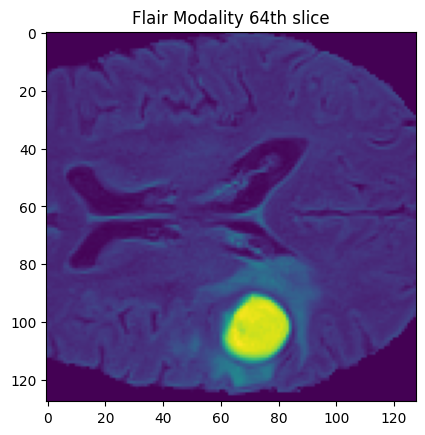

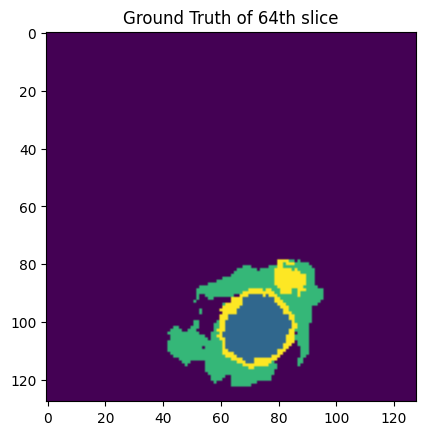

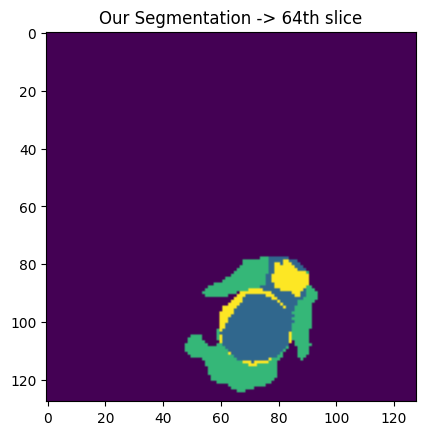

In [ ]:
x = all_images[92]
print("Results on image number 92")
folder_path = path + '/' + x;
modalities = os.listdir(folder_path)
modalities.sort()
data = np.zeros((240,240,155,4))
w = 0
for j in range(len(modalities)-1):
  image_path = folder_path + '/' + modalities[j]
  if not(image_path.find('seg.nii') == -1):
    img = nib.load(image_path);
    image_data2 = img.get_fdata()
    image_data2 = np.asarray(image_data2)
    print("Entered ground truth")
  else:
    img = nib.load(image_path);
    image_data = img.get_fdata()
    image_data = np.asarray(image_data)
    image_data = standardize(image_data)
    data[:,:,:,w] = image_data
    print("Entered modality")
    w = w+1

print(data.shape)
print(image_data2.shape)

reshaped_data=data[56:184,75:203,13:141,:]
reshaped_data=reshaped_data.reshape(1,128,128,128,4)
reshaped_image_data2=image_data2[56:184,75:203,13:141]


reshaped_image_data2=reshaped_image_data2.reshape(1,128,128,128)
reshaped_image_data2[reshaped_image_data2==4] = 3

print(reshaped_image_data2.shape)

print(reshaped_data.shape)
print(reshaped_image_data2.shape)
print(type(reshaped_data))

Y_hat = model.predict(x=reshaped_data)
Y_hat = np.argmax(Y_hat,axis=-1)
import matplotlib.pyplot as plt
#import matplotlib.pyplot as plt
img = reshaped_data[0,:,:,64,0]
imgplot = plt.imshow(img)
plt.title('Flair Modality 64th slice')
plt.savefig('Flair')
plt.show()

img2 = reshaped_image_data2[0,:,:,64]
imgplot2 = plt.imshow(img2)
plt.title('Ground Truth of 64th slice')
plt.savefig('Ground_Truth')
plt.show()

img3 = Y_hat[0,:,:,64]
imgplot3 = plt.imshow(img3)
plt.title('Our Segmentation -> 64th slice')
plt.savefig('Our Segmentation')
plt.show()

